# Human Numbers

In [1]:
from fastai.text.all import *

In [3]:
bs = 64

# Data

In [4]:
path = untar_data(URLs.HUMAN_NUMBERS)

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls()

(#2) [Path('valid.txt'),Path('train.txt')]

In [7]:
def readnums(fname): return ', '.join(num.strip() for num in (path/fname).readlines())

In [8]:
train_txt = readnums('train.txt')
train_txt[:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [9]:
valid_txt = readnums('valid.txt')
valid_txt[-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [12]:
train_tok = tokenize1(train_txt, tok=WordTokenizer())
valid_tok = tokenize1(valid_txt, tok=WordTokenizer())

In [13]:
train_tok

(#50079) ['xxbos','one',',','two',',','three',',','four',',','five'...]

In [16]:
dsets = Datasets([train_tok, valid_tok], tfms=[Numericalize], dl_type=LMDataLoader, splits=[[0], [1]])

In [17]:
dls = dsets.dataloaders(bs=bs, val_bs=bs)

In [2]:
train_tok

NameError: name 'train_tok' is not defined

In [19]:
valid_tok

(#13017) ['xxbos','eight','thousand','one',',','eight','thousand','two',',','eight'...]

In [24]:
dsets.show((dsets.train[0][0][:80],))

In [26]:
len(dls.valid)

3

In [28]:
first(dls.valid)

(LMTensorText([[ 2, 19, 11,  ..., 19, 11, 37],
         [ 9, 19, 11,  ...,  9, 19, 11],
         [11, 27, 18,  ..., 11, 12, 10],
         ...,
         [11, 20, 10,  ..., 36,  9, 20],
         [10, 22, 18,  ..., 10, 23, 18],
         [ 9, 20, 11,  ...,  9, 20, 11]], device='cuda:0'),
 TensorText([[19, 11, 12,  ..., 11, 37,  9],
         [19, 11, 23,  ..., 19, 11, 25],
         [27, 18,  9,  ..., 12, 10, 12],
         ...,
         [20, 10, 17,  ...,  9, 20, 11],
         [22, 18,  9,  ..., 23, 18,  9],
         [20, 11, 20,  ..., 20, 11, 20]], device='cuda:0'))

In [29]:
dls.seq_len

72

In [30]:
13017/72/bs

2.8248697916666665

In [32]:
it = iter(dls.valid)
x1, y1 = next(it)
x2, y2 = next(it)
x3, y3 = next(it)
it.close()

In [35]:
x1.numel() + x2.numel() + x3.numel() # This is the closest multiple of 64 below 13017

12992

In [36]:
x1.shape, y1.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [38]:
x3.shape, y3.shape

(torch.Size([64, 59]), torch.Size([64, 59]))

In [39]:
x1[0]

LMTensorText([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19,
        11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,
         9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19,
        11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37],
       device='cuda:0')

In [40]:
y1[0]

TensorText([19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11,
        16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9,
        19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19, 11,
        33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37,  9],
       device='cuda:0')

In [42]:
v = dls.vocab

In [44]:
' '.join([v[x] for x in x1[0]])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen'

In [46]:
' '.join(v[y] for y in y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen ,'

In [47]:
' '.join(v[x] for x in x2[0])

', eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two , eight thousand thirty three'

In [48]:
' '.join(v[y] for y in y2[0])

'eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two , eight thousand thirty three ,'

# Single fully connected model

In [49]:
dls = dsets.dataloaders(bs=bs, seq_len=3)

In [50]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [53]:
nv = len(v)
nv

40

In [54]:
nh = 64

In [55]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4(input,target): return accuracy(input, target[:,-1]) # target[bs, predicting last word of every sq]

In [56]:
class Model0(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self,x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1] > 1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [60]:
learn = Learner(dls, Model0(), loss_func=loss4, metrics=acc4)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.019054606556892395)

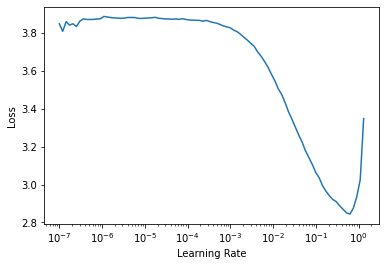

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(6, 5e-2)

epoch,train_loss,valid_loss,acc4,time
0,1.400636,2.333910,0.403493,00:05
1,1.353624,2.500271,0.399357,00:05
2,1.331168,2.320118,0.323300,00:06
3,1.307701,2.670008,0.317785,00:05
4,1.328736,2.384800,0.318704,00:06
5,1.321821,2.522910,0.319393,00:05


# Same thing with a loop

In [65]:
class Model1(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self,x):
        h = torch.zeros((x.shape[0],nh), device=x.device)
        for i in range(x.shape[1]):
            h += self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [66]:
learn = Learner(dls, Model1(), loss4, metrics=acc4)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.019054606556892395)

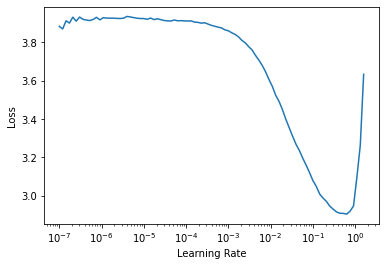

In [67]:
learn.lr_find()

In [68]:
learn.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,acc4,time
0,1.380122,2.428737,0.379825,00:06
1,1.353970,2.285774,0.321691,00:05
2,1.355999,2.289802,0.321691,00:06


# Multi fully connected model

In [70]:
dls = dsets.dataloaders(bs=bs, seq_len=20)

In [71]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [78]:
class Model2(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
    
    def forward(self,x):
        h = torch.zeros((x.shape[0],nh), device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)

In [82]:
learn = Learner(dls, Model2(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.015848932787775993)

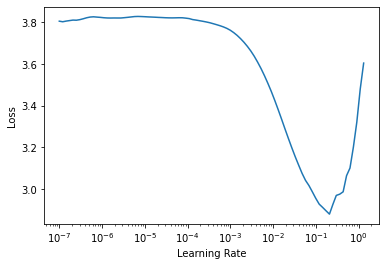

In [83]:
learn.lr_find()

In [84]:
learn.fit_one_cycle(4, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.875207,2.275039,0.396141,00:01
1,1.576217,2.059858,0.448485,00:01
2,1.417744,2.047362,0.452225,00:01
3,1.309193,2.051514,0.452415,00:01


# Maintain state

In [85]:
class Model3(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs,nh).cuda()
        
    def forward(self,x):
        res = []
        if x.shape[0] != self.h.shape[0]: self.h = torch.zeros((x.shape[0],nh), device=x.device())
        h = self.h
        for i in range(x.shape[1]):
            h += self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
            res.append(h)
        self.h =h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res
    
    def reset(self): self.h = torch.zeros(bs,nh).cuda()

In [86]:
learn = Learner(dls, Model3(), CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.015848932787775993)

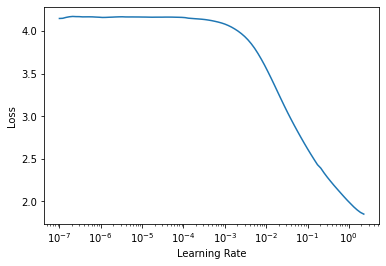

In [87]:
learn.lr_find()

In [88]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.019777,0.175641,0.960369,00:01
1,0.387891,0.144885,0.960156,00:01
2,0.213687,0.144227,0.957363,00:01
3,0.145772,0.148792,0.957292,00:01
4,0.115120,0.150204,0.958144,00:01
5,0.098922,0.146004,0.958807,00:01
6,0.088216,0.144652,0.959991,00:01
7,0.079759,0.152770,0.961174,00:01
8,0.071820,0.154058,0.959422,00:01
9,0.065783,0.155719,0.959967,00:01


# nn.RNN

In [95]:
class Model4(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1,bs,nh).cuda()
        
    def forward(self,x):
        if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(1, x.shape[0], nh).cuda()
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [101]:
learn = Learner(dls, Model4(), CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.015848932787775993)

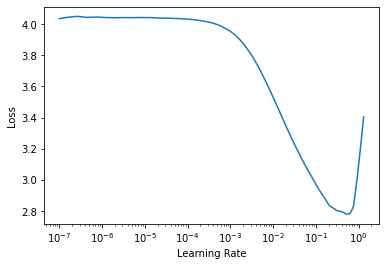

In [102]:
learn.lr_find()

In [103]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.644959,3.249791,0.213163,00:01
1,2.808036,2.181911,0.463305,00:01
2,2.093880,2.003294,0.325308,00:01
3,1.736008,1.961722,0.338258,00:01
4,1.537582,1.881324,0.470360,00:01
5,1.351088,1.859615,0.473722,00:01
6,1.171154,1.711280,0.496307,00:01
7,1.010583,1.630796,0.513897,00:01
8,0.864415,1.663763,0.508002,00:02
9,0.739893,1.575637,0.525758,00:01


# 2-layer GRU

In [104]:
class Model5(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh,nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2,bs,nh).cuda()
        
    def forward(self,x):
        if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(2,x.shape[0],nh).cuda()
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [107]:
learn = Learner(dls, Model5(), CrossEntropyLossFlat(), metrics=accuracy)

In [108]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.650829,2.326489,0.363755,00:01
1,1.466271,1.710471,0.639631,00:01
2,0.707851,1.052041,0.815175,00:01
3,0.347521,0.905035,0.836837,00:01
4,0.177718,0.738343,0.857481,00:01
5,0.096766,0.820581,0.844129,00:01
6,0.056375,0.824606,0.853835,00:01
7,0.034969,0.840749,0.850687,00:01
8,0.023480,0.881565,0.846094,00:01
9,0.017253,0.874597,0.844768,00:01
